In [1]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
import random
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")
from mfilter.implementations.simulate import SimulateSignal
from mfilter.regressions import *
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples
from mfilter.filter import *

0.0 0.009405031258646175
0.0 0.010355056565846234
-0.11730347985412362 79.16970539194574 39.54036750816393 39.53980936682457


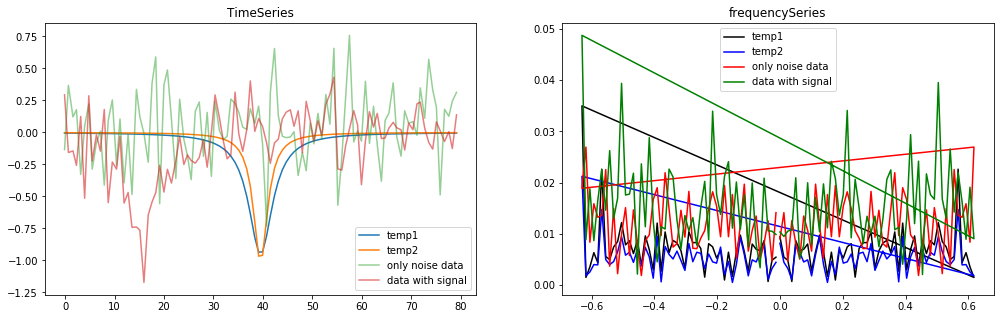

In [2]:
# define times and plot
delta_t = 0.8
n = 100
struct = "slight"
times = TimesSamples(n=n, delta=delta_t, struct=struct)

# delta_t = 1.3
# Fs = 1 / delta_t
# n = 128 * 4
# times = TimesSamples(initial_array=np.arange(tsamples) * delta_t)

def eval(U0, t0, tE, fs, times):
    """Evaluate microlens event at given time array, return magnitude difference"""
    u = np.sqrt(U0**2 + ((times - t0)  /tE )**2)
    A = (u**2 + 2.) / (u * np.sqrt(u**2 + 3))
    dm = - 2.5 * np.log10(fs*(A - 1) + 1)
    return dm

dwindow = signal.tukey(n, alpha=1./8)
dwindow = None
t0 = min(times) + times.duration/2
tE = 0.8 
U0 = 3 #1.3 
fs = 24 #16.9
val = eval(U0, times[n//5], tE, fs, times)

np.random.seed(1)
noise_data = np.random.normal(0, 0.2, n)
data = val + noise_data

val = eval(U0, t0, tE, fs, times)

tE = 0.5
U0 = 2.8
fs = 23
val2 = eval(U0, t0, tE, fs, times)

val = TimeSeries(val, times=times)
val2 = TimeSeries(val2, times=times)
# np.random.seed(2345)
data0 = TimeSeries(np.random.normal(0, 0.3, n), times=times)
data = TimeSeries(data, times=times)


fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(17, 5))
ax1.plot(times, val, label="temp1")
ax1.plot(times, val2, label="temp2")
ax1.plot(times, data0, alpha=0.5, label="only noise data")
ax1.plot(times, data, alpha=0.6, label="data with signal")
ax1.legend()
ax1.set_title("TimeSeries")
method = "nfft"
htilde1 = val.to_frequencyseries(window=dwindow, method=method)
htilde2 = val2.to_frequencyseries(method=method, window=dwindow)
stilde = data.to_frequencyseries(method=method, window=dwindow)
stilde0 = data0.to_frequencyseries(method=method, window=dwindow)
freqs = stilde.frequency_object
ax2.plot(freqs, abs(htilde1), 'k', label="temp1")
ax2.plot(freqs, abs(htilde2), 'b', label="temp2")
ax2.plot(freqs, abs(stilde0), 'r', label="only noise data")
ax2.plot(freqs, abs(stilde), 'g', label="data with signal")
ax2.legend()
ax2.set_title("frequencySeries")
print(freqs[0], abs(htilde1[0]))
print(freqs[0], abs(stilde[0]))

# here we see that regression somehow produce always 0 output on regression, i.e., always found 0 value in
# frequency domain at frequency 0, we could try to avoid this problem by not taking the 0 frequency
print(min(times), max(times), np.mean(times), np.median(times))

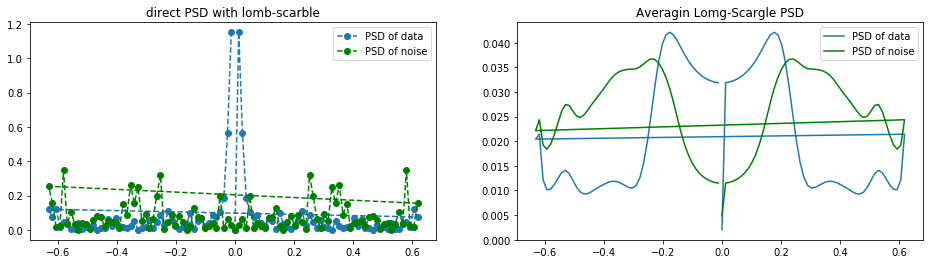

In [3]:
# here we donw have method for estimate noise psd yet, so we are going to use directly the psd of noise
psd = data.psd(freqs)
psd0 = data0.psd(freqs)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(freqs, psd, 'o--', label="PSD of data")
ax1.plot(freqs, psd0, 'go--', label="PSD of noise")
ax1.set_title("direct PSD with lomb-scarble")
ax1.legend()

# here we see that psd here and on pyCBC are quite similar expect for the "peaks" present here because this is 
# not an average PSD (welch it is). We see from the pyCBC PSD that noise PSD has values between 0 and 0.5 
#(checked visualy), here we see some values over 0.1 but the mayority under 0.1 and almos under 0.5, we could try 
# to do a simples averagle over same interval duration

def average_psd(segment_duration, oversampling_rate, timeSeries, freqs):
    N = timeSeries.duration / segment_duration
    n_seg = (int(N) - 1) / (1-oversampling_rate)
#     print(n_seg)
    t = 0
    psd = FrequencySeries(np.zeros(len(freqs)), frequency_grid=freqs, epoch=timeSeries.epoch)
    counter = 0
    while t < timeSeries.duration - segment_duration:
        aux_timeseries = timeSeries.get_time_slice(t, t+segment_duration)
        window = signal.windows.hann(len(aux_timeseries))
        aux_timeseries *= window
        W = (window ** 2).sum() / len(window)
        W = 1
        psd += (aux_timeseries.psd(freqs) / W)
        t += (1-oversampling_rate) * segment_duration
        counter += 1
#     print("counter is: ", counter)
    aux_timeseries = timeSeries.get_time_slice(timeSeries.duration - segment_duration, timeSeries.duration)
    window = signal.windows.hann(len(aux_timeseries))
    aux_timeseries *= window
    W = (window ** 2).sum() / len(window)
    W = 1
    psd += (aux_timeseries.psd(freqs) / W)
    psd /= (counter+1)
    
    return psd
seg_dur = times.duration//10
# seg_dur = 9
avg_psd = average_psd(seg_dur, 0.5, data, freqs)
# avg_psd = average_psd(seg_dur, 0.5, TimeSeries(noise_data, times=times), freqs)
avg_psd0 = average_psd(seg_dur, 0.5, data0, freqs)

ax2.plot(freqs, avg_psd, label="PSD of data")
ax2.plot(freqs, avg_psd0, 'g', label="PSD of noise")
ax2.set_title("Averagin Lomg-Scargle PSD")
ax2.legend()

psd = avg_psd
psd0 = avg_psd0

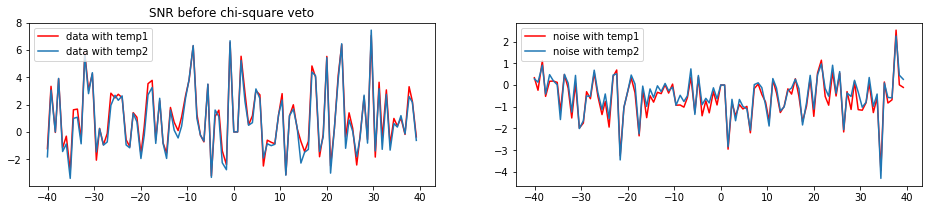

In [4]:
snr = matched_filter(htilde1, stilde, psd=psd, method=method, times=times, unitary_energy=True)
snr2 = matched_filter(htilde2, stilde, psd=psd, method=method, times=times, unitary_energy=True)

snr0 = matched_filter(htilde1, stilde0, psd=psd0, method=method, times=times, unitary_energy=True)
snr02 = matched_filter(htilde2, stilde0, psd=psd0, method=method, times=times, unitary_energy=True)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 3), sharey=False)
ax1.plot(times - times[n//2], (np.roll(snr, n//2)).real, 'r', label="data with temp1")
ax1.plot(times - times[n//2], (np.roll(snr2, n//2)).real, label="data with temp2")
ax1.legend()
ax1.set_title("SNR before chi-square veto")

ax2.plot(times - times[n//2], (np.roll(snr0, n//2)).real, 'r', label="noise with temp1")
ax2.plot(times - times[n//2], (np.roll(snr02, n//2)).real, label="noise with temp2")
ax2.legend()

In [5]:
# using the chi statistic

def power_chisq(htilde, stilde, num_bins, psd, times):
    
    bins = power_chisq_bins(htilde, num_bins, psd)
    
    
    snr, corr, norm = matched_filter_core(htilde, stilde, psd=psd, method="nfft", times=times)
    
    return power_chisq_from_precomputed(corr, snr, norm, bins, times), len(bins)

def power_chisq_bins(htilde, num_bins, psd):
    sigma_vec = sigmasq_series(htilde, psd)
    
    return power_chisq_bins_from_sigmasq_series(sigma_vec, num_bins)

def sigmasq_series(htilde, psd):
    autocorr = htilde.conj() * htilde / psd
    return autocorr.cumsum()

def power_chisq_bins_from_sigmasq_series(sigma_vec, num_bins):
    sigmasq = sigma_vec[len(sigma_vec)-2]
    edge_vec = np.arange(0, num_bins) * sigmasq / num_bins
    bins = np.searchsorted(sigma_vec, edge_vec, side='right')
    bins = np.append(bins, len(sigma_vec) - 1)
    bins = np.unique(bins)
    if len(bins) != num_bins + 1:
        print("using {} bins instead of {}".format(len(bins), num_bins))
    return bins

def power_chisq_from_precomputed(corr, snr, norm, bins, times):
    qtilde = FrequencySeries(np.zeros(len(corr)), frequency_grid=corr.frequency_object, dtype=corr.dtype,
                            epoch=corr.epoch)
    chisq = TimeSeries(np.zeros(len(snr)), times=snr.times, dtype=snr.dtype, epoch=snr.epoch)
    num_bins = len(bins) - 1
    
    for j in range(num_bins):
        k_min = int(bins[j])
        k_max = int(bins[j+1])
        qtilde[k_min:k_max] = corr[k_min:k_max]
        q = qtilde.to_timeseries(method=method, times=times)
        qtilde.fill(0)
        chisq += q.squared_norm()
        
    chisq = (chisq * num_bins - snr.squared_norm()) * (norm ** 2)
    chisq = TimeSeries(chisq, times=snr.times, epoch=snr.epoch)
    return chisq
    



In [6]:
divs = 40
chsq, n_bins = power_chisq(htilde1, stilde, divs, psd, times)
chsq /= (n_bins * 2) - 2
chsq2, n_bins = power_chisq(htilde2, stilde, divs, psd, times)
chsq2 /= (n_bins * 2) - 2
chsq0, n_bins = power_chisq(htilde1, stilde0, divs, psd0, times)
chsq0 /= (n_bins * 2) - 2
chsq02, n_bins = power_chisq(htilde2, stilde0, divs, psd0, times)
chsq02 /= (n_bins * 2) - 2

using 29 bins instead of 40
using 30 bins instead of 40
using 29 bins instead of 40
using 30 bins instead of 40


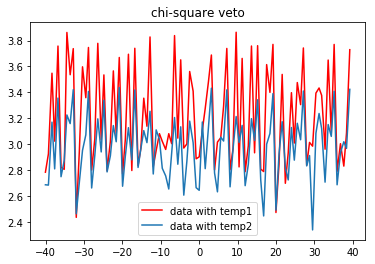

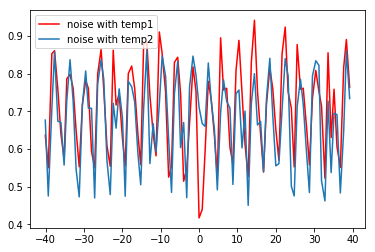

In [7]:
plt.plot(times - times[n//2], np.roll(chsq.real, n//2), 'r', label="data with temp1")
plt.plot(times - times[n//2], np.roll(chsq2.real, n//2), label="data with temp2")
plt.title("chi-square veto")
plt.legend()
plt.figure()
plt.plot(times - times[n//2], np.roll(chsq0.real, n//2), 'r', label="noise with temp1")
plt.plot(times - times[n//2], np.roll(chsq02.real, n//2), label="noise with temp2")
plt.legend()

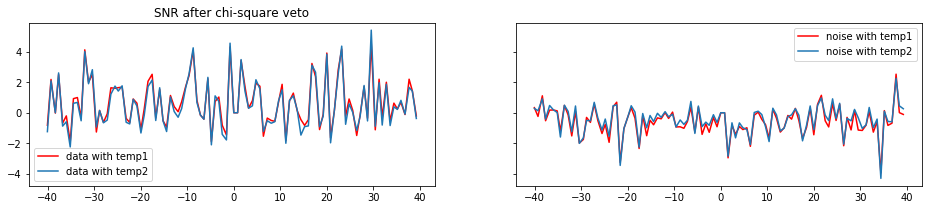

In [8]:
def weighted_snr(snr, chisq):
    for i in range(len(chisq)):
        if chisq[i] > 1:
            snr[i] /= ((1 + chisq[i]**(3))/2.0)**(1.0/6)
        
    return snr

w_snr = weighted_snr(snr, chsq)
w_snr2 = weighted_snr(snr2, chsq2)

w_snr0 = weighted_snr(snr0, chsq0)
w_snr02 = weighted_snr(snr02, chsq02)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 3), sharey=True)

ax1.plot(times - times[n//2], (np.roll(w_snr, n//2)).real, 'r', label="data with temp1")
ax1.plot(times - times[n//2], (np.roll(w_snr2, n//2)).real, label="data with temp2")

ax2.plot(times - times[n//2], (np.roll(w_snr0, n//2)).real, 'r', label="noise with temp1")
ax2.plot(times - times[n//2], (np.roll(w_snr02, n//2)).real, label="noise with temp2")
ax1.legend()
ax1.set_title("SNR after chi-square veto")
ax2.legend()

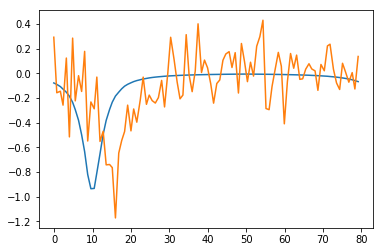

In [10]:
plt.plot(times, np.roll(val, len(val)-np.argmax(w_snr.real)))
plt.plot(times, data)